# Club de lecture 12 Oct. 2017: interpolation spatiale et apprentissage automatique

Ce travail est inspiré des recommandations d'Erwan et du site internet http://geologyandpython.com de Bruno Ruas de Pinho. Plus aprticulièrement, le code de la page http://geologyandpython.com/ML-spatial-data.html est repris dans ce Notebook.

## Importer les packages nécessaires

In [20]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pyproj
from shapely import geometry
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score

from pykrige.ok import OrdinaryKriging
import pykrige.kriging_tools as kt

plt.style.use('classic')
%matplotlib inline

## Importer les projections et datum nécessaires à la conversion des coordonnées depuis lattitude/longitude vers UTM

In [2]:
# from North American Datum 1927
p1 = pyproj.Proj(proj='latlong', datum='NAD27')

# to WGS84 UTM Zone 16
p2 = pyproj.Proj(proj='utm', zone=16, datum='WGS84')

## Importer les données mag.

Ces données sont libres d'accès sur le site internet de l'USGS ( https://mrdata.usgs.gov/ ). Elles correspondent au relevé NURE (Iron River Quadrangle, Michigan and Wisconsin).

Les valeurs qui nous intéressent ici sont celles de magnétisme résiduel.

In [3]:
column_names = 'line fid time day year latitude longitude radalt totmag resmag diurnal geology resmagCM4'.split(' ')
mag_data = pd.read_csv('Michigan\iron_river_mag.xyz.gz',
                        delim_whitespace=True, names=column_names, usecols=['latitude', 'longitude', 'totmag', 'resmag'])
mag_data.head()

,latitude,longitude,totmag,resmag
0,46.0237,-89.9960,59280.2,-518.0
1,46.0237,-89.9950,59283.0,-515.2
2,46.0237,-89.9944,59283.8,-514.5
3,46.0237,-89.9934,59281.0,-517.3
4,46.0237,-89.9928,59276.5,-521.8


Les coordonnées UTM sont ajoutées.

In [4]:
mag_data['E_utm'], mag_data['N_utm'] = pyproj.transform(p1, p2, mag_data.longitude.values, mag_data.latitude.values)

Un tri dans les données est effectué pour enlever les outliers.

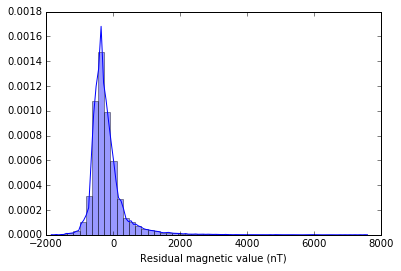

In [5]:
ax = sns.distplot(mag_data.resmag, axlabel='Residual magnetic value (nT)')
plt.show()

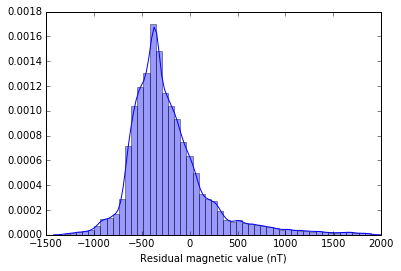

In [6]:
mag_data = mag_data[mag_data.resmag>mag_data.resmag.quantile(0.002)]
mag_data = mag_data[mag_data.resmag<mag_data.resmag.quantile(0.99)]
ax = sns.distplot(mag_data.resmag, axlabel='Residual magnetic value (nT)')
plt.show()

In [7]:
#Define the minimun and maximun values for the Colormap.
vmin_mag = -1000
vmax_mag = 750

Ci dessous, la distribution finale des valeurs de magnetisme résiduel et leur position dans l'espace. La grille de mesure est bien distribuée sur la zone, ce qui facilitera les interpolations spatiales.

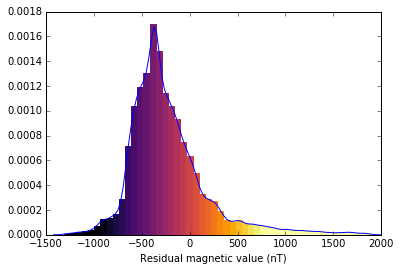

In [8]:
#Let's check how these values go:
norm = colors.Normalize(vmin=vmin_mag, vmax=vmax_mag)
cmap = 'inferno'
colormap = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
ax = sns.distplot(mag_data['resmag'], axlabel='Residual magnetic value (nT)')
for patch in ax.patches:
    patch.set_color(colormap.to_rgba(patch.xy[0]))
    #patch.set_color(plt.cm.viridis(norm(patch.xy[0])))
    patch.set_alpha(1)

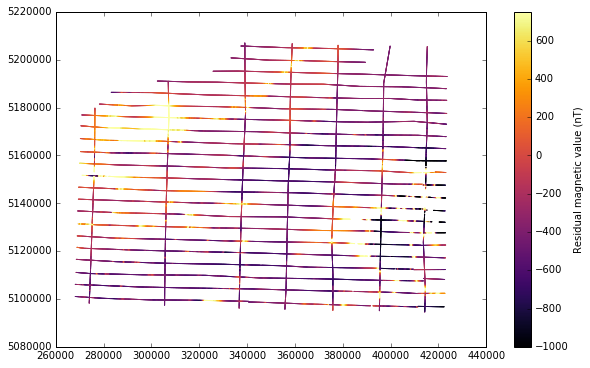

In [9]:
plt.scatter(mag_data.E_utm, mag_data.N_utm, linewidths=0, cmap=cmap, s=1, c=mag_data.resmag, vmin=vmin_mag, vmax=vmax_mag)
plt.colorbar(label=u'Residual magnetic value (nT)')
plt.gca().set_aspect('equal')
plt.gcf().set_size_inches(10, 6)

## Creation de la grille d'interpolation

Une grille avec espacement de 250m est créée sur la zone d'interpolation. Les coordonnées X et Y sont calculées pour chaque point de la grille.

In [10]:
mag_data['geometry'] = [geometry.Point(x, y) for x, y in zip(mag_data['E_utm'], mag_data['N_utm'])]
mag_data = gpd.GeoDataFrame(mag_data, geometry='geometry', crs="+init=epsg:32616")

In [11]:
multipoints = geometry.MultiPoint(mag_data['geometry'].values)
bounds = multipoints.envelope

In [12]:
# Defineing pixel size
pixel_size = 250

#Now, define the range of coordinate values to be processed as a function to the pixel size.
x_box, y_box = bounds.exterior.coords.xy
x_range = np.arange(np.min(x_box) - np.min(x_box) % pixel_size, np.max(x_box), pixel_size)
y_range = np.arange(np.min(y_box) - np.min(y_box) % pixel_size, np.max(y_box), pixel_size)[::-1]

#Define shape
shape = (len(y_range), len(x_range))

#Define extent
extent = xmin, xmax, ymin, ymax = x_range.min(), x_range.max(), y_range.min(), y_range.max()

#Check the information we just added.
print ('''Array info:
rows: {}, columns: {}\nxmin: {}, xmax: {}\nymin: {}, ymax: {}
'''.format(shape[0], shape[1], xmin, xmax, ymin, ymax))

Array info:
rows: 451, columns: 623
xmin: 268000.0, xmax: 423500.0
ymin: 5094500.0, ymax: 5207000.0



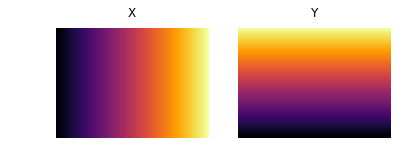

In [13]:
#From the ranges, let's call meshgrid to get the coordinates in 2D arrays.
x_mesh, y_mesh = np.meshgrid(x_range, y_range)
#Check if its correct:
fig, axes = plt.subplots(1, 2)
for ax, data, title in zip(axes.ravel(), [x_mesh, y_mesh], ['X', 'Y']):
    ax.matshow(data, extent=extent, cmap='inferno')
    ax.set_axis_off()
    ax.set_title(title)

Les points de mesures mag sont projetées sur la grille d'interpolation.

In [15]:
#On the same array than rad data, we can convert each magnetic sample's UTM coordinate to index values of the array.
mag_data.loc[:, 'X_INDEX'] = ((mag_data['E_utm'] - xmin) / pixel_size).astype(int)
mag_data.loc[:, 'Y_INDEX'] = (shape[0] - ((mag_data['N_utm'] - ymin) / pixel_size)).astype(int)

In [16]:
#Create an empty array with the shape that we defined previously and add the mag values into the positions defined by the index.
mag_array = np.zeros(shape)
mag_array[:] = np.nan
mag_array[mag_data.Y_INDEX, mag_data.X_INDEX] = mag_data['resmag']
#have to replace the 0s to be able to use the np.where function
mag_array[mag_array==0] = 0.01

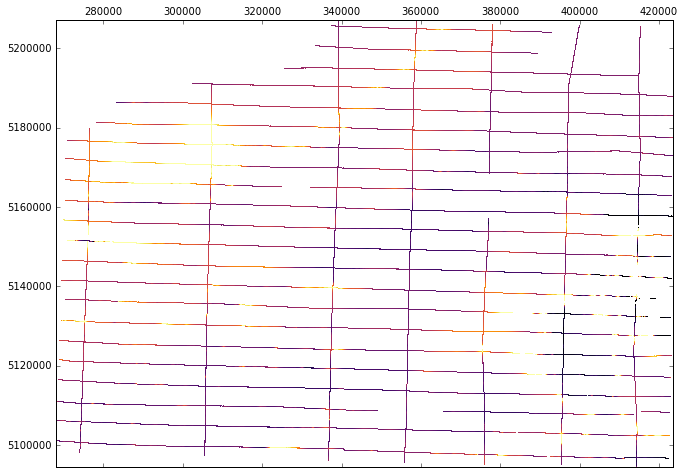

In [36]:
plt.matshow(mag_array, cmap=cmap, vmin=vmin_mag, vmax=vmax_mag, extent=extent)
plt.gcf().set_size_inches(12, 8)

## Interpolation par krigeage

Ci-dessous, la grille est interpolée par krigeage. Seuls 5000 points pris aux hasard sont utilisés pour batîr le modèle de krigeage. Le variogramme est ensuite "amélioré" à la main. La prédiction se fait seulement avec les 500 points les plus proches du point à prédire pour ne pas surcharger la mémoire vive.

La carte du résultat et le r2 obtenu sur les points de mesure sont montrés.

In [18]:
y_train = mag_array[np.isfinite(mag_array)]
y_train = y_train.reshape(y_train.shape[0], 1)
x_index_train, y_index_train = np.where(np.isfinite(mag_array))
x_index_pred, y_index_pred = np.where(mag_array)

X_train = np.vstack([x_index_train, y_index_train]).T
X_pred = np.vstack([x_index_pred, y_index_pred]).T

data_train = np.concatenate((X_train, y_train), axis=1)

from sklearn.utils import resample
data_train = resample(data_train, n_samples=5000)

In [21]:
# Variogram parameters: {'sill': s, 'range': r, 'nugget': n}
OK = OrdinaryKriging(data_train[:, 0].astype(float), data_train[:, 1].astype(float), data_train[:, 2].astype(float), nlags=25,
                     variogram_model = 'spherical', variogram_parameters= [170000.0, 110.0, 60000.0],
                     verbose=False, enable_plotting=False)

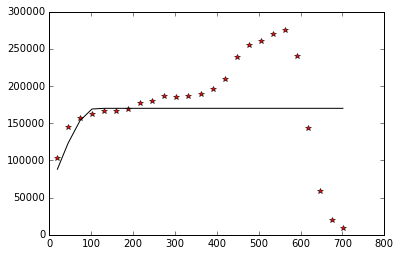

In [22]:
OK.display_variogram_model()

In [23]:
y_pred, y_var = OK.execute(style='grid', xpoints=np.unique(x_index_train).astype(float),
                           ypoints=np.unique(y_index_train).astype(float), backend='C', n_closest_points=500)

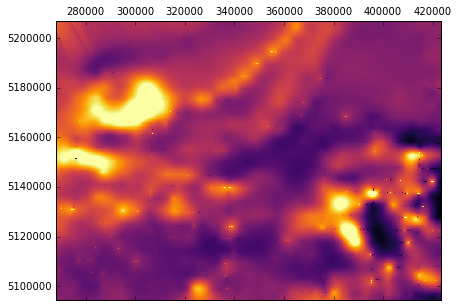

In [24]:
mag_krig_pred = y_pred.T
plt.matshow(y_pred.T, extent=extent, cmap=cmap, vmin=vmin_mag, vmax=vmax_mag)
plt.gcf().set_size_inches(8, 5)

In [25]:
y_test = mag_array[np.isfinite(mag_array)]
y_pred = mag_krig_pred[np.isfinite(mag_array)]

print ('r2 score of the kriging: ' + str(r2_score(y_test, y_pred)))

0.819186005992


## Interpolation par apprentissage automatique

L'interpolation par apprentissage automatique se fait en plusieurs étapes. D'abords, trois algorithmes de méthodes d'ensemble sont testés avec comme variables d'entrée les coordonnées X et Y et comme variable de sortie les valeurs mag. Aucun paramétrage n'est fait.

Ensuite, une série de variables correspondant aux coordonnées X et Y pivotées selon une série de 60 angles. Une série de 60 jeux de coordonnées à orientation variable sont donc produits. Les mêmes algorithmes de méthode d'ensemble sont à nouveau entraînés avec ces nouvelles variables.

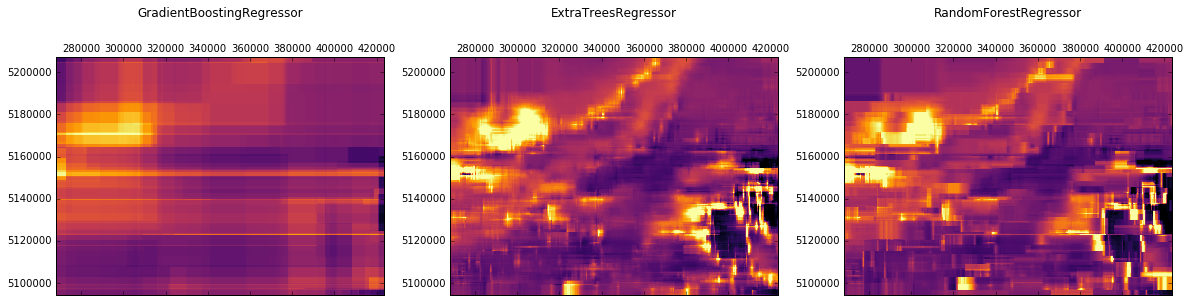

In [26]:
regrs = [GradientBoostingRegressor(),
        ExtraTreesRegressor(),
        RandomForestRegressor()]

y_train = mag_array[np.isfinite(mag_array)]
x_index_train, y_index_train = np.where(np.isfinite(mag_array))
x_index_pred, y_index_pred = np.where(mag_array)

X_train = np.vstack([x_index_train, y_index_train]).T
X_pred = np.vstack([x_index_pred, y_index_pred]).T

fig, axes = plt.subplots(1, 3, figsize=(20,10))

for ax, regr, title in zip(axes.ravel(), regrs, ['GradientBoostingRegressor',
                                                 'ExtraTreesRegressor',
                                                 'RandomForestRegressor']):
    regr.fit(X=X_train, y=y_train)
    y_pred = regr.predict(X=X_pred)

    ax.matshow(y_pred.reshape(shape), extent=extent, cmap=cmap, vmin=vmin_mag, vmax=vmax_mag)
    ax.set_title(title, y=1.15)

In [27]:
# Feature engineering
n_angles = 60

X_var, Y_var, angle = np.meshgrid(x_range, y_range, n_angles)

angles = np.deg2rad(np.linspace(0, 180, n_angles, endpoint=False))

X = X_var + np.tan(angles) * Y_var
X[:,:,int(n_angles/2)+1:] = np.flipud(np.fliplr(X[:,:,int(n_angles/2)+1:]))

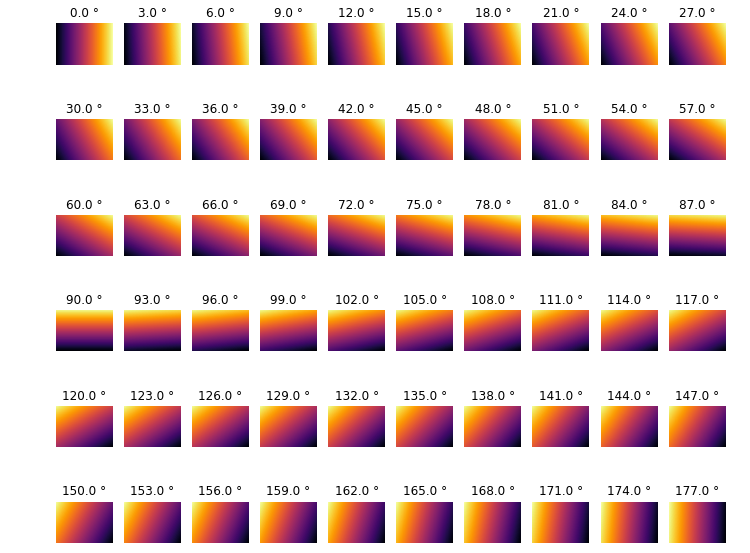

In [28]:
fig, axes = plt.subplots(6, 10, figsize=(12, 10))
for ax, data, angle in zip(axes.ravel(), np.dsplit(X, 60), angles):
    ax.matshow(data.squeeze(), extent=extent, cmap='inferno'); ax.set_axis_off()
    ax.set_title(u'{} °'.format(str(np.rad2deg(angle))))

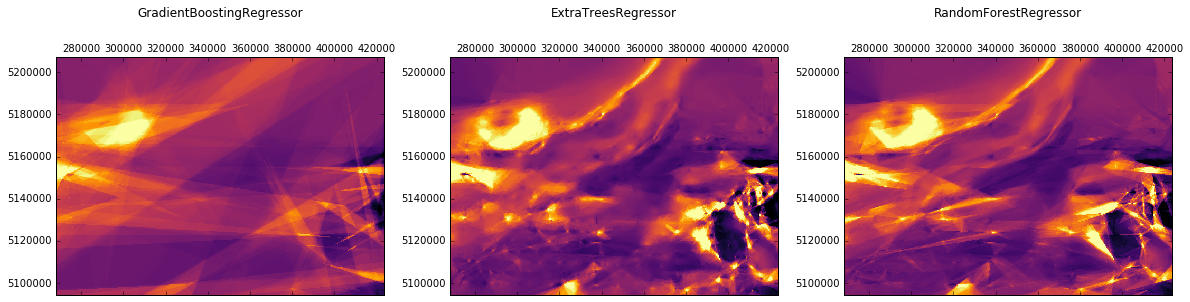

In [29]:
#Finally, sample the rotated arrays and train the Regressors:
X_train = X[x_index_train, y_index_train]
X_pred = X.reshape(-1, 60)

fig, axes = plt.subplots(1, 3, figsize=(20,10))

for ax, regr, title in zip(axes.ravel(), regrs, ['GradientBoostingRegressor',
                                                 'ExtraTreesRegressor',
                                                 'RandomForestRegressor']):
    regr.fit(X=X_train, y=y_train)
    y_pred = regr.predict(X=X_pred)

    ax.matshow(y_pred.reshape(shape), extent=extent, cmap=cmap, vmin=vmin_mag, vmax=vmax_mag)
    ax.set_title(title, y=1.15)

Les résultats suggèrent que l'algorithme ExtraTreesRegressor est le plus performant. En utilisant TPOT (et manuellement), une optimisation des paramètres est effectuées afin d'améliorer la qualité de la prédiction. Le score r2 obtenu sur les données d'entrainement est calculé.

In [ ]:
import tpot

tpot_config = {'sklearn.ensemble.ExtraTreesRegressor': {'n_estimators': [20, 50, 100, 200, 500, 1000], 
                                                        'max_features': [0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0], 
                                                       'max_depth': [2, 3, 4, 6, 8, 10, 12, 14], 
                                                       'min_samples_split': [2, 5, 10, 20, 40, 80, 160, 300, 500], 
                                                       'min_samples_leaf': [1, 2, 5, 10, 20, 40, 80, 160, 300, 500]}}
tregr = tpot.TPOTRegressor(n_jobs=2, verbosity=2, scoring='r2', generations=100, max_time_mins=30, warm_start=True)

In [ ]:
tregr.fit(X_train, y_train)

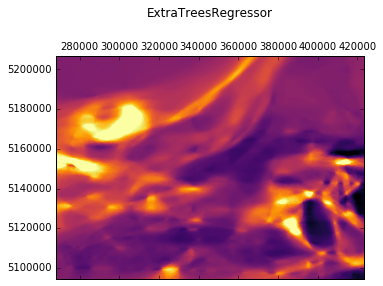

In [30]:
regr = ExtraTreesRegressor(bootstrap=False, min_samples_leaf=19, min_samples_split=8, n_estimators=100)
regr.fit(X=X_train, y=y_train)
y_pred_regr = regr.predict(X=X_pred)

fig, ax = plt.subplots()
ax.matshow(y_pred_regr.reshape(shape), extent=extent, cmap=cmap, vmin=vmin_mag, vmax=vmax_mag)
ax.set_title('ExtraTreesRegressor', y=1.15)

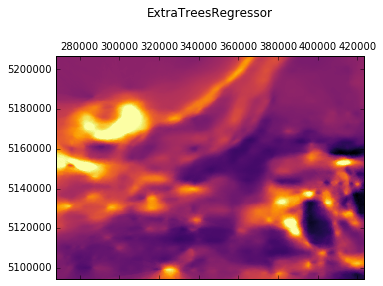

In [31]:
regr = ExtraTreesRegressor(bootstrap=True, max_features=0.2, min_samples_leaf=10, min_samples_split=6, n_estimators=100)
regr.fit(X=X_train, y=y_train)
y_pred_regr = regr.predict(X=X_pred)

fig, ax = plt.subplots()
ax.matshow(y_pred_regr.reshape(shape), extent=extent, cmap=cmap, vmin=vmin_mag, vmax=vmax_mag)
ax.set_title('ExtraTreesRegressor', y=1.15)

In [34]:
y_test = mag_array[np.isfinite(mag_array)]
y_pred = regr.predict(X=X_train)

print ('r2 score of the kriging: ' + str(r2_score(y_test, y_pred)))

r2 score of the kriging: 0.835251836774


### Orientation des strutures.

En utilisant la classe feature_importances du modèle prédictif, on peut retrouver la contribution de chaque angle pour la prédiction de l'interpolation. Le résultat montré dans un diagramme en rose montre les orientations dominantes des strutures magnétiques.

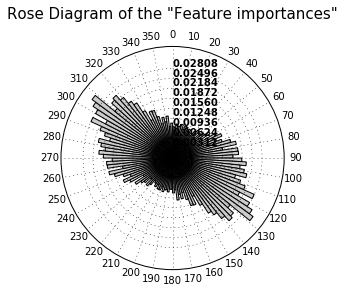

In [32]:
import mplstereonet

Feature_importances = np.concatenate([regr.feature_importances_, regr.feature_importances_])
Angles_feat_imp = np.concatenate([np.rad2deg(angles), np.rad2deg(angles)+180])

fig = plt.figure()
fig.add_axes()
ax = fig.add_subplot(111, projection='polar')

ax.bar(np.deg2rad(Angles_feat_imp), Feature_importances, 
       width=np.deg2rad(3), bottom=0.0, color='.8', edgecolor='k')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_thetagrids(np.arange(0, 360, 10), labels=np.arange(0, 360, 10))
max_value = Feature_importances.max()
ax.set_rgrids(np.arange(max_value/10, max_value, max_value/10), angle=0, weight= 'black')
ax.set_title('Rose Diagram of the "Feature importances"', y=1.10, fontsize=15)